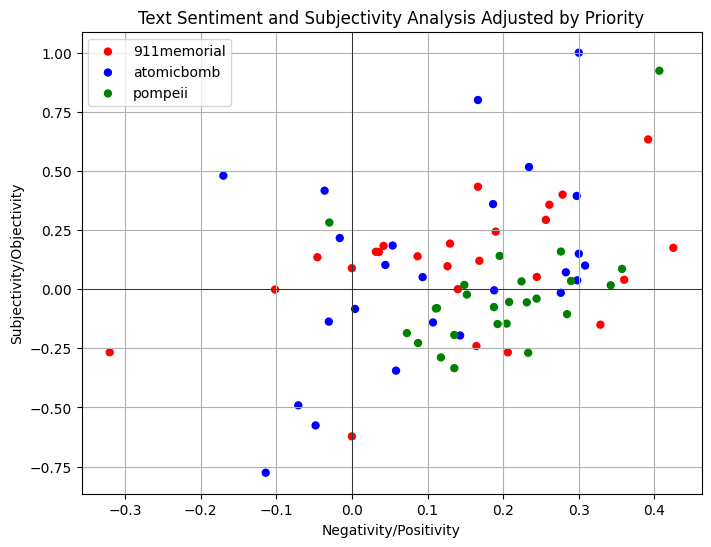

In [ ]:
import json
from textblob import TextBlob
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data['dataset'], data['priority']

def analyze_text(texts):
    results = []
    for text in texts:
        analysis = TextBlob(text)
        x = analysis.sentiment.polarity
        y = 2 * analysis.sentiment.subjectivity - 1
        results.append((x, y))
    return results

def apply_priority(results, priorities):
    adjusted_results = []
    for (x, y), priority in zip(results, priorities):
        adjusted_x = float(x) * float(priority)
        adjusted_y = float(y) * float(priority)
        adjusted_results.append((adjusted_x, adjusted_y))
    return adjusted_results

def plot_results(file_paths, colors):
    plt.figure(figsize=(8, 6))
    for file_path, color in zip(file_paths, colors):
        texts, priorities = load_data(file_path)
        results = analyze_text(texts)
        adjusted_results = apply_priority(results, priorities)
        x_vals, y_vals = zip(*adjusted_results)
        edge_colors = ['black' if priority == 1.2 else 'none' for priority in priorities]  # Create edge colors based on priority
        line_widths = [2 if priority == 1.2 else 0.5 for priority in priorities]  # Increased linewidth for visibility
        plt.scatter(x_vals, y_vals, color=color, edgecolor=edge_colors, linewidth=line_widths, label=file_path.split('/')[-1].split('.')[0])

    plt.title('Text Sentiment and Subjectivity Analysis Adjusted by Priority')
    plt.xlabel('Negativity/Positivity')
    plt.ylabel('Subjectivity/Objectivity')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.legend()
    plt.show()

file_paths = ['dataset/911memorial.json', 'dataset/atomicbomb.json', 'dataset/pompeii.json']
colors = ['red', 'blue', 'green']

plot_results(file_paths, colors)


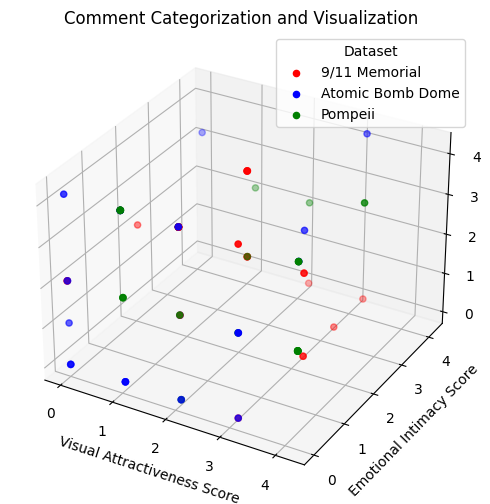

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data['dataset']

def compute_similarity(comments, keywords):
    # Generate embeddings for comments and keywords
    comment_embeddings = embed(comments)
    keyword_embeddings = embed(keywords)
    # Calculate cosine similarity
    similarity = np.inner(comment_embeddings, keyword_embeddings)
    return similarity

def compute_scores(comments, categories, base_scores):
    all_scores = []  # To store numeric scores for plotting
    for comment in comments:
        numeric_scores = []
        for aspect, keywords in categories.items():
            similarity = compute_similarity([comment], keywords)
            idx = np.argmax(similarity)
            max_value = np.max(similarity)
            if idx >= len(base_scores[aspect]):
                idx = len(base_scores[aspect]) - 1
            score = base_scores[aspect][idx] + max_value * 0.05  # Scaling similarity
            numeric_scores.append(score)
        all_scores.append(numeric_scores)  # Collect numeric scores for plotting
    return np.array(all_scores)

categories = {
    'visual_attractiveness': ['splendid', 'beautiful', 'sight', 'unattractive', 'disgust'],
    'emotional_intimacy': ['belonging', 'affectionate', 'relate', 'connection', 'alienation', 'distant', 'ignorant'],
    'importance': ['substantial', 'major', 'mundane', 'minor', 'useless']
}

base_scores = {
    'visual_attractiveness': [4.2, 3.15, 2.1, 1.05, 0],
    'emotional_intimacy': [4.2, 3.15, 2.1, 1.05, 0],
    'importance': [4.2, 3.15, 2.1, 1.05, 0]
}

file_paths = ['dataset/911memorial.json', 'dataset/atomicbomb.json', 'dataset/pompeii.json']
dataset_labels = ['9/11 Memorial', 'Atomic Bomb Dome', 'Pompeii']
colors = ['red', 'blue', 'green']  # Assigning colors to each file
all_comments = []
color_map = []

for file_path, color in zip(file_paths, colors):
    comments = load_data(file_path)
    all_comments.extend(comments)
    color_map.extend([color] * len(comments))  # Extend color mapping for each comment

scores = compute_scores(all_comments, categories, base_scores)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = scores[:, 0], scores[:, 1], scores[:, 2]
scatter = ax.scatter(xs, ys, zs, c=color_map)

for dataset_label, color in zip(dataset_labels, colors):
    ax.scatter([], [], [], c=color, label=dataset_label)

ax.set_xlabel('Visual Attractiveness Score')
ax.set_ylabel('Emotional Intimacy Score')
ax.set_zlabel('Importance Score')
plt.title('Comment Categorization and Visualization')
plt.legend(title="Dataset")
plt.show()
